# Load Files

In [2]:
import re
import pandas as pd
import os
import seaborn as sns
import numpy as np
import warnings
import math
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [3]:
house_train = pd.read_csv('Datasets/train_Wenchang.csv')
house_test = pd.read_csv('Datasets/test_Wenchang.csv')

# Pre Processing

In [4]:
# Combining both house_train and house_test to clean data
house_train # 80 columns
house_test # 79 columns. need SalePrice placeholder
house_test['SalePrice'] = np.nan

# house_test starts on index row 1460 
house_full = pd.concat([house_train, house_test], axis = 0)

# Feature Engineering


### Bath Capacity

In [5]:
# Total Number of bathrooms
house_full['TotBath'] = house_full.FullBath + .5*house_full.HalfBath

# Replace zeros with median
house_full.TotBath.replace(0, house_full.TotBath.median(), inplace=True)

# Replace zero bedrooms with median bedroom #. This is so we can engineer a feature
house_full.BedroomAbvGr.replace(0, house_full.BedroomAbvGr.median(), inplace=True)
house_full.BedroomAbvGr.unique()

# Bath Capacity. The higher the ratio the better
house_full['Bath_Capacity'] = house_full.TotBath / house_full.BedroomAbvGr
house_full.Bath_Capacity.unique()

array([ 0.83333333,  0.66666667,  0.33333333,  0.625     ,  1.5       ,
        1.        ,  0.5       ,  0.75      ,  0.875     ,  0.375     ,
        0.16666667,  1.16666667,  1.25      ,  0.6       ,  0.25      ,
        2.        ,  0.2       ,  0.4       ,  0.7       ,  0.41666667,
        1.33333333,  0.3       ])

### Parking Capacity

In [6]:
# Parking Capacity. The higher the better
house_full['Parking_Capacity'] = house_full.GarageCars / house_full.BedroomAbvGr
house_full.Parking_Capacity.unique()

array([ 0.66666667,  1.        ,  0.75      ,  2.        ,  0.5       ,
        0.33333333,  0.        ,  0.25      ,  0.6       ,  1.5       ,
        3.        ,  0.4       ,  0.16666667,  0.2       ,  1.33333333,
        2.5       ])

### Split Data back into Training/Testing

In [7]:
# split full data back to training and test before imputation
house_train = house_full.iloc[0:1460,:]
house_test = house_full.iloc[1460:,]

### Check for Null in Training

In [8]:
# Check for  null values in training data
house_train.isnull().any().sum() # none

0

### Check for Null in Test

In [9]:
# Check for  null values in training data
house_test.isnull().any().sum() # Only SalePrice is still Null

1

### Finishing touch, delete index column

In [10]:
del house_train['Unnamed: 0']
del house_test['Unnamed: 0']

In [11]:
house_train.SalePrice.head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [12]:
house_test.SalePrice.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: SalePrice, dtype: float64

# Normalize SalePrice variable

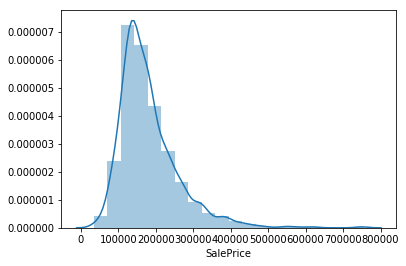

In [13]:
sns.distplot(house_train.SalePrice, bins = 20)
sns.distplot([np.log(house_train.SalePrice + 1)], bins = 20)

# Converting SalePrice to Log
house_train.SalePrice = np.log(house_train.SalePrice)


# Dummify and Seperate Training Set to Another Training and Test Set

In [30]:
from copy import deepcopy
import sklearn.model_selection as ms

# Creating a deep copy of training set 
house_train_copy = deepcopy(house_train)

house_train_x = pd.get_dummies(house_train_copy.drop('SalePrice', axis = 1))
house_train_y = house_train_copy.SalePrice.values.reshape(-1,1)

# Create sperate out original training set to the new training and test set
X_train, X_test, y_train, y_test = ms.train_test_split(house_train_x, \
                                                       house_train_y, \
                                                       test_size = 1/5, \
                                                       random_state = 0)


# Fitting Decision Tree

In [15]:
from sklearn import tree

# Train decision tree
#tree_model_1 = tree.DecisionTreeRegressor(max_depth = 5)
tree_model_1 = tree.DecisionTreeRegressor()
tree_model_1.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### First try, got 99% R sq on training, and 73% R sq on test

In [16]:
print('Training Score:',tree_model_1.score(x_train, y_train))
print('Test Score:',tree_model_1.score(x_test, y_test))

Training Score: 0.999999995271
Test Score: 0.681888904295


### Error : Training RMSE = .1582 , Testing RMSE = .1938

In [17]:
print('Training RMSE:' , math.sqrt(mean_squared_error(y_train, tree_model_1.predict(x_train))))
print('Test RMSE:' , math.sqrt(mean_squared_error(y_test, tree_model_1.predict(x_test))))

Training RMSE: 2.7632366048037177e-05
Test RMSE: 0.21945835502855834


### These were the top 10 variables

Engineered features not showing up

In [19]:
result_tree1 = pd.concat([ pd.DataFrame(x_train.columns.values),  pd.DataFrame(tree_model_1.feature_importances_)], axis = 1)
result_tree1.columns = ['Feature', 'Importance']
result_tree1 = result_tree1.sort_values(by = 'Importance', ascending = False).head(10)
result_tree1

,Feature,Importance
23,OverallQual,0.556029
13,GrLivArea,0.129436
26,TotalBsmtSF,0.075100
3,BsmtFinSF1,0.024802
22,OverallCond,0.020157
70,CentralAir_Y,0.019792
36,Parking_Capacity,0.017954
16,LotArea,0.011866
15,KitchenAbvGr,0.011249
211,MSZoning_C (all),0.008578


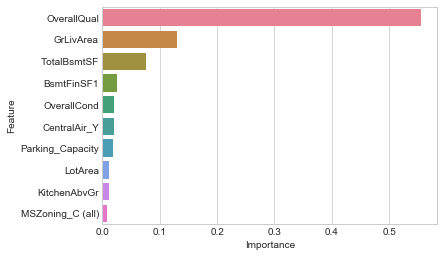

In [23]:
#sns.color_palette("husl")
sns.set_style("whitegrid")
sns.barplot(x = 'Importance', y = 'Feature', data=result_tree1, palette="husl")

# Tuning Decision Tree

In [39]:
from sklearn.grid_search import GridSearchCV

tree_model = tree.DecisionTreeRegressor()

param_grid = [{'max_depth': np.arange(1,21), 
              'min_samples_leaf': np.arange(1,10)}]

tree_model.set_params(random_state = 0)

grid_search = GridSearchCV(tree_model, param_grid=param_grid, cv = 5, verbose = 2)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] ........................ max_depth=1, min_samples_leaf=1 -   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] ........................ max_depth=1, min_samples_leaf=1 -   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] ........................ max_depth=1, min_samples_leaf=1 -   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] ........................ max_depth=1, min_samples_leaf=1 -   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] ........................ max_depth=1, min_samples_leaf=1 -   0.0s
[CV] max_depth=1, min_samples_leaf=2 .................................
[CV] ........................ max_depth=1, min_samples_leaf=2 -   0.0s
[CV] max_depth=1, min_samples_leaf=2 .................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................ max_depth=1, min_samples_leaf=4 -   0.0s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] ........................ max_depth=1, min_samples_leaf=4 -   0.0s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] ........................ max_depth=1, min_samples_leaf=4 -   0.0s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] ........................ max_depth=1, min_samples_leaf=4 -   0.0s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] ........................ max_depth=1, min_samples_leaf=4 -   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] ........................ max_depth=1, min_samples_leaf=5 -   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] ........................ max_depth=1, min_samples_leaf=5 -   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] .

[CV] ........................ max_depth=2, min_samples_leaf=6 -   0.0s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] ........................ max_depth=2, min_samples_leaf=7 -   0.0s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] ........................ max_depth=2, min_samples_leaf=7 -   0.0s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] ........................ max_depth=2, min_samples_leaf=7 -   0.0s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] ........................ max_depth=2, min_samples_leaf=7 -   0.0s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] ........................ max_depth=2, min_samples_leaf=7 -   0.0s
[CV] max_depth=2, min_samples_leaf=8 .................................
[CV] ........................ max_depth=2, min_samples_leaf=8 -   0.0s
[CV] max_depth=2, min_samples_leaf=8 .................................
[CV] .

[CV] ........................ max_depth=4, min_samples_leaf=1 -   0.0s
[CV] max_depth=4, min_samples_leaf=1 .................................
[CV] ........................ max_depth=4, min_samples_leaf=1 -   0.0s
[CV] max_depth=4, min_samples_leaf=1 .................................
[CV] ........................ max_depth=4, min_samples_leaf=1 -   0.0s
[CV] max_depth=4, min_samples_leaf=1 .................................
[CV] ........................ max_depth=4, min_samples_leaf=1 -   0.0s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] ........................ max_depth=4, min_samples_leaf=2 -   0.0s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] ........................ max_depth=4, min_samples_leaf=2 -   0.0s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] ........................ max_depth=4, min_samples_leaf=2 -   0.0s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] .

[CV] ........................ max_depth=5, min_samples_leaf=3 -   0.0s
[CV] max_depth=5, min_samples_leaf=4 .................................
[CV] ........................ max_depth=5, min_samples_leaf=4 -   0.0s
[CV] max_depth=5, min_samples_leaf=4 .................................
[CV] ........................ max_depth=5, min_samples_leaf=4 -   0.0s
[CV] max_depth=5, min_samples_leaf=4 .................................
[CV] ........................ max_depth=5, min_samples_leaf=4 -   0.0s
[CV] max_depth=5, min_samples_leaf=4 .................................
[CV] ........................ max_depth=5, min_samples_leaf=4 -   0.0s
[CV] max_depth=5, min_samples_leaf=4 .................................
[CV] ........................ max_depth=5, min_samples_leaf=4 -   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] ........................ max_depth=5, min_samples_leaf=5 -   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] .

[CV] ........................ max_depth=6, min_samples_leaf=8 -   0.0s
[CV] max_depth=6, min_samples_leaf=8 .................................
[CV] ........................ max_depth=6, min_samples_leaf=8 -   0.0s
[CV] max_depth=6, min_samples_leaf=8 .................................
[CV] ........................ max_depth=6, min_samples_leaf=8 -   0.0s
[CV] max_depth=6, min_samples_leaf=8 .................................
[CV] ........................ max_depth=6, min_samples_leaf=8 -   0.0s
[CV] max_depth=6, min_samples_leaf=9 .................................
[CV] ........................ max_depth=6, min_samples_leaf=9 -   0.0s
[CV] max_depth=6, min_samples_leaf=9 .................................
[CV] ........................ max_depth=6, min_samples_leaf=9 -   0.0s
[CV] max_depth=6, min_samples_leaf=9 .................................
[CV] ........................ max_depth=6, min_samples_leaf=9 -   0.0s
[CV] max_depth=6, min_samples_leaf=9 .................................
[CV] .

[CV] ........................ max_depth=8, min_samples_leaf=1 -   0.0s
[CV] max_depth=8, min_samples_leaf=2 .................................
[CV] ........................ max_depth=8, min_samples_leaf=2 -   0.0s
[CV] max_depth=8, min_samples_leaf=2 .................................
[CV] ........................ max_depth=8, min_samples_leaf=2 -   0.0s
[CV] max_depth=8, min_samples_leaf=2 .................................
[CV] ........................ max_depth=8, min_samples_leaf=2 -   0.0s
[CV] max_depth=8, min_samples_leaf=2 .................................
[CV] ........................ max_depth=8, min_samples_leaf=2 -   0.0s
[CV] max_depth=8, min_samples_leaf=2 .................................
[CV] ........................ max_depth=8, min_samples_leaf=2 -   0.0s
[CV] max_depth=8, min_samples_leaf=3 .................................
[CV] ........................ max_depth=8, min_samples_leaf=3 -   0.0s
[CV] max_depth=8, min_samples_leaf=3 .................................
[CV] .

[CV] ........................ max_depth=9, min_samples_leaf=4 -   0.0s
[CV] max_depth=9, min_samples_leaf=5 .................................
[CV] ........................ max_depth=9, min_samples_leaf=5 -   0.0s
[CV] max_depth=9, min_samples_leaf=5 .................................
[CV] ........................ max_depth=9, min_samples_leaf=5 -   0.0s
[CV] max_depth=9, min_samples_leaf=5 .................................
[CV] ........................ max_depth=9, min_samples_leaf=5 -   0.0s
[CV] max_depth=9, min_samples_leaf=5 .................................
[CV] ........................ max_depth=9, min_samples_leaf=5 -   0.0s
[CV] max_depth=9, min_samples_leaf=5 .................................
[CV] ........................ max_depth=9, min_samples_leaf=5 -   0.0s
[CV] max_depth=9, min_samples_leaf=6 .................................
[CV] ........................ max_depth=9, min_samples_leaf=6 -   0.0s
[CV] max_depth=9, min_samples_leaf=6 .................................
[CV] .

[CV] ....................... max_depth=10, min_samples_leaf=8 -   0.0s
[CV] max_depth=10, min_samples_leaf=8 ................................
[CV] ....................... max_depth=10, min_samples_leaf=8 -   0.0s
[CV] max_depth=10, min_samples_leaf=9 ................................
[CV] ....................... max_depth=10, min_samples_leaf=9 -   0.0s
[CV] max_depth=10, min_samples_leaf=9 ................................
[CV] ....................... max_depth=10, min_samples_leaf=9 -   0.0s
[CV] max_depth=10, min_samples_leaf=9 ................................
[CV] ....................... max_depth=10, min_samples_leaf=9 -   0.0s
[CV] max_depth=10, min_samples_leaf=9 ................................
[CV] ....................... max_depth=10, min_samples_leaf=9 -   0.0s
[CV] max_depth=10, min_samples_leaf=9 ................................
[CV] ....................... max_depth=10, min_samples_leaf=9 -   0.0s
[CV] max_depth=11, min_samples_leaf=1 ................................
[CV] .

[CV] ....................... max_depth=12, min_samples_leaf=2 -   0.0s
[CV] max_depth=12, min_samples_leaf=3 ................................
[CV] ....................... max_depth=12, min_samples_leaf=3 -   0.0s
[CV] max_depth=12, min_samples_leaf=3 ................................
[CV] ....................... max_depth=12, min_samples_leaf=3 -   0.0s
[CV] max_depth=12, min_samples_leaf=3 ................................
[CV] ....................... max_depth=12, min_samples_leaf=3 -   0.0s
[CV] max_depth=12, min_samples_leaf=3 ................................
[CV] ....................... max_depth=12, min_samples_leaf=3 -   0.0s
[CV] max_depth=12, min_samples_leaf=3 ................................
[CV] ....................... max_depth=12, min_samples_leaf=3 -   0.0s
[CV] max_depth=12, min_samples_leaf=4 ................................
[CV] ....................... max_depth=12, min_samples_leaf=4 -   0.0s
[CV] max_depth=12, min_samples_leaf=4 ................................
[CV] .

[CV] ....................... max_depth=13, min_samples_leaf=6 -   0.0s
[CV] max_depth=13, min_samples_leaf=6 ................................
[CV] ....................... max_depth=13, min_samples_leaf=6 -   0.0s
[CV] max_depth=13, min_samples_leaf=6 ................................
[CV] ....................... max_depth=13, min_samples_leaf=6 -   0.0s
[CV] max_depth=13, min_samples_leaf=7 ................................
[CV] ....................... max_depth=13, min_samples_leaf=7 -   0.0s
[CV] max_depth=13, min_samples_leaf=7 ................................
[CV] ....................... max_depth=13, min_samples_leaf=7 -   0.0s
[CV] max_depth=13, min_samples_leaf=7 ................................
[CV] ....................... max_depth=13, min_samples_leaf=7 -   0.0s
[CV] max_depth=13, min_samples_leaf=7 ................................
[CV] ....................... max_depth=13, min_samples_leaf=7 -   0.0s
[CV] max_depth=13, min_samples_leaf=7 ................................
[CV] .

[CV] ....................... max_depth=15, min_samples_leaf=1 -   0.0s
[CV] max_depth=15, min_samples_leaf=1 ................................
[CV] ....................... max_depth=15, min_samples_leaf=1 -   0.0s
[CV] max_depth=15, min_samples_leaf=1 ................................
[CV] ....................... max_depth=15, min_samples_leaf=1 -   0.0s
[CV] max_depth=15, min_samples_leaf=1 ................................
[CV] ....................... max_depth=15, min_samples_leaf=1 -   0.0s
[CV] max_depth=15, min_samples_leaf=2 ................................
[CV] ....................... max_depth=15, min_samples_leaf=2 -   0.0s
[CV] max_depth=15, min_samples_leaf=2 ................................
[CV] ....................... max_depth=15, min_samples_leaf=2 -   0.0s
[CV] max_depth=15, min_samples_leaf=2 ................................
[CV] ....................... max_depth=15, min_samples_leaf=2 -   0.0s
[CV] max_depth=15, min_samples_leaf=2 ................................
[CV] .

[CV] ....................... max_depth=16, min_samples_leaf=4 -   0.0s
[CV] max_depth=16, min_samples_leaf=4 ................................
[CV] ....................... max_depth=16, min_samples_leaf=4 -   0.0s
[CV] max_depth=16, min_samples_leaf=4 ................................
[CV] ....................... max_depth=16, min_samples_leaf=4 -   0.0s
[CV] max_depth=16, min_samples_leaf=4 ................................
[CV] ....................... max_depth=16, min_samples_leaf=4 -   0.0s
[CV] max_depth=16, min_samples_leaf=4 ................................
[CV] ....................... max_depth=16, min_samples_leaf=4 -   0.0s
[CV] max_depth=16, min_samples_leaf=5 ................................
[CV] ....................... max_depth=16, min_samples_leaf=5 -   0.0s
[CV] max_depth=16, min_samples_leaf=5 ................................
[CV] ....................... max_depth=16, min_samples_leaf=5 -   0.0s
[CV] max_depth=16, min_samples_leaf=5 ................................
[CV] .

[CV] max_depth=17, min_samples_leaf=7 ................................
[CV] ....................... max_depth=17, min_samples_leaf=7 -   0.0s
[CV] max_depth=17, min_samples_leaf=7 ................................
[CV] ....................... max_depth=17, min_samples_leaf=7 -   0.0s
[CV] max_depth=17, min_samples_leaf=7 ................................
[CV] ....................... max_depth=17, min_samples_leaf=7 -   0.0s
[CV] max_depth=17, min_samples_leaf=8 ................................
[CV] ....................... max_depth=17, min_samples_leaf=8 -   0.0s
[CV] max_depth=17, min_samples_leaf=8 ................................
[CV] ....................... max_depth=17, min_samples_leaf=8 -   0.0s
[CV] max_depth=17, min_samples_leaf=8 ................................
[CV] ....................... max_depth=17, min_samples_leaf=8 -   0.0s
[CV] max_depth=17, min_samples_leaf=8 ................................
[CV] ....................... max_depth=17, min_samples_leaf=8 -   0.0s
[CV] m

[CV] ....................... max_depth=19, min_samples_leaf=1 -   0.0s
[CV] max_depth=19, min_samples_leaf=1 ................................
[CV] ....................... max_depth=19, min_samples_leaf=1 -   0.0s
[CV] max_depth=19, min_samples_leaf=1 ................................
[CV] ....................... max_depth=19, min_samples_leaf=1 -   0.0s
[CV] max_depth=19, min_samples_leaf=2 ................................
[CV] ....................... max_depth=19, min_samples_leaf=2 -   0.0s
[CV] max_depth=19, min_samples_leaf=2 ................................
[CV] ....................... max_depth=19, min_samples_leaf=2 -   0.0s
[CV] max_depth=19, min_samples_leaf=2 ................................
[CV] ....................... max_depth=19, min_samples_leaf=2 -   0.0s
[CV] max_depth=19, min_samples_leaf=2 ................................
[CV] ....................... max_depth=19, min_samples_leaf=2 -   0.0s
[CV] max_depth=19, min_samples_leaf=2 ................................
[CV] .

[CV] ....................... max_depth=20, min_samples_leaf=4 -   0.0s
[CV] max_depth=20, min_samples_leaf=4 ................................
[CV] ....................... max_depth=20, min_samples_leaf=4 -   0.0s
[CV] max_depth=20, min_samples_leaf=5 ................................
[CV] ....................... max_depth=20, min_samples_leaf=5 -   0.0s
[CV] max_depth=20, min_samples_leaf=5 ................................
[CV] ....................... max_depth=20, min_samples_leaf=5 -   0.0s
[CV] max_depth=20, min_samples_leaf=5 ................................
[CV] ....................... max_depth=20, min_samples_leaf=5 -   0.0s
[CV] max_depth=20, min_samples_leaf=5 ................................
[CV] ....................... max_depth=20, min_samples_leaf=5 -   0.0s
[CV] max_depth=20, min_samples_leaf=5 ................................
[CV] ....................... max_depth=20, min_samples_leaf=5 -   0.0s
[CV] max_depth=20, min_samples_leaf=6 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   27.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [40]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 9}

Best hyperparamters are max depth = 11, min_samples_leaf = 8

### Refit Decision Tree with Best Parameters

In [44]:
tree_model = tree.DecisionTreeRegressor(max_depth = 11, 
                                        min_samples_leaf = 8)

tree_model.fit(x_train, y_train)

#tree_model = tree.DecisionTreeRegressor(max_depth = 9, 
#                                        min_samples_leaf = 9)

#tree_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### R sq is now 91% on training and 77% on test

Though training score increased alot while Test score improves slightly from 75% to 77%

In [45]:
print('Training Score:',tree_model.score(x_train, y_train))
print('Test Score:',tree_model.score(x_test, y_test))

Training Score: 0.911885038298
Test Score: 0.772913556577


### Error : Training RMSE = .1192 , Testing RMSE = .1854

Both Training and Test RMSE lowered in tuned tree. Test RMSE went from .1938 to .1854

In [46]:
print('Training RMSE:' , math.sqrt(mean_squared_error(y_train, tree_model.predict(x_train))))
print('Test RMSE:' , math.sqrt(mean_squared_error(y_test, tree_model.predict(x_test))))

Training RMSE: 0.11927836467652658
Test RMSE: 0.18542074217492654


# Plot Training vs Test Error (Depth)

In [54]:
list(subset)

[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

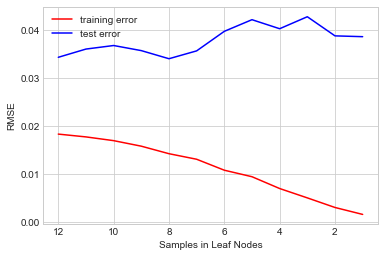

In [86]:
subset = range(12, 0, -1)
train_error = []
test_error = []
for i in subset:
    tree_model.set_params(max_depth=11, min_samples_leaf = i)
    tree_model.fit(x_train, y_train)
    train_error.append(mean_squared_error(y_train, tree_model.predict(x_train)))
    test_error.append(mean_squared_error(y_test, tree_model.predict(x_test)))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot( subset, train_error, c='red', label='training error')
plt.plot(subset, test_error, c='blue', label='test error')
ax.set(xlabel='Samples in Leaf Nodes', ylabel='RMSE')
ax.invert_xaxis()
#plt.ylim(0, 0.18)
plt.legend()
plt.show()

### Top 10 Important Variables for this fitted tree

Both of the bath engineerd features continue to rank higher in importance compared to the original

In [21]:
result_tree2 = pd.concat([pd.DataFrame(x_train.columns.values),pd.DataFrame(tree_model.feature_importances_)], axis = 1)
result_tree2.columns = ['Feature','Importance']
result_tree2 = result_tree2.sort_values(by = 'Importance', ascending = False).head(10)
result_tree2

,Feature,Importance
23,OverallQual,0.607759
13,GrLivArea,0.134133
26,TotalBsmtSF,0.082345
3,BsmtFinSF1,0.023896
70,CentralAir_Y,0.021704
36,Parking_Capacity,0.019062
22,OverallCond,0.017090
15,KitchenAbvGr,0.012336
0,1stFlrSF,0.008531
25,TotRmsAbvGrd,0.007056


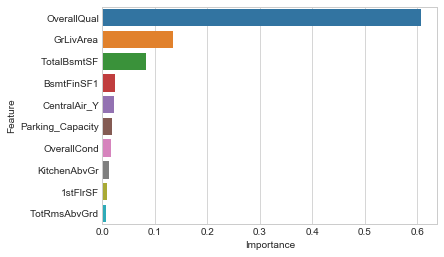

In [22]:
sns.set_style("whitegrid")
sns.barplot(x = 'Importance', y = 'Feature', data=result_tree2)

# Thoughts so far...

I think we can do better on the test score...our model is only fit on one set of observations, so there is high variance in our model.

However, if we fit the model on MULTIPLE sets of observations then we can lower this variance by averaging a bunch of weak models together

Lets try attacking with Bagged Trees to decrease the variance!

# Fitting Bagged Trees

In [163]:
from sklearn.ensemble import BaggingRegressor

bag_tree = BaggingRegressor(
        tree.DecisionTreeRegressor(),
        n_estimators = 500, 
        max_samples = round(len(x_train)*.67), # bag two thirds of training set
        bootstrap = True,      
        random_state = 0,
        oob_score = True
        )

bag_tree.fit(x_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=783, n_estimators=500, n_jobs=1, oob_score=True,
         random_state=0, verbose=0, warm_start=False)

### R sq for Training is 97%, OOB 87% and Test 87%. Test score is close to our OOB score.

Bagged Tree model gave us a much higher Test score, goign from 77% to 87% R sqaured!

In [164]:
print('Training Score:', bag_tree.score(x_train, y_train))
print('OOB Score:', bag_tree.oob_score_)
print('Test Score:', bag_tree.score(x_test, y_test))

Training Score: 0.96564487431
OOB Score: 0.869147517835
Test Score: 0.871577103208


### Error Rate: Training RMSE =  .0745 , Test RMSE = .1394

Test RMSE in Bagged Tree continues to go down .1854 to .1394 from the last model (Tuned Decision Tree)

In [165]:
print('Training RMSE:' , math.sqrt(mean_squared_error(y_train, bag_tree.predict(x_train))))

print('Test RMSE:' , math.sqrt(mean_squared_error(y_test, bag_tree.predict(x_test))))

Training RMSE: 0.07447879108934419
Test RMSE: 0.13943889797618808


# Score Improvement Chart (From Decision Tree to Bagged Tree)

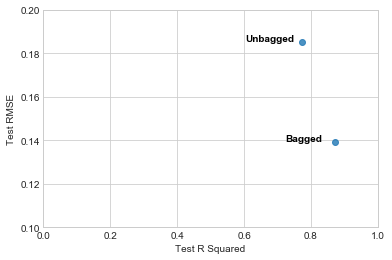

In [138]:
r = np.array([.7729,.8716])
rmse = np.array([.1854, .1394])

fig, ax = plt.subplots()
sns.regplot(x=r, y=rmse, label = 'label', fit_reg=False)
plt.text(.7729 - .17, .1854, "Unbagged", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(.8716 - .15, .1394, "Bagged", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set(xlabel='Test R Squared', ylabel='Test RMSE')
ax.set_xlim(0,1)
ax.set_ylim(0.1000,0.2)
plt.show()

## Thoughts so far:

Much improved training and test scores!
But, perhaps these trees are WAY too correlated, still increasing too much variance in our model.
Same predictors will be chosen at the top of all our trees
Lets try attacking Random Forest to decorrelate! Go!

# Fitting Random Forest: First Attempt

In [25]:
from sklearn.ensemble import RandomForestRegressor
import math

rf_tree_1 = RandomForestRegressor(n_estimators = 500,
                                max_features = round(math.sqrt(len(x_train.columns))),
                                bootstrap = True,
                                oob_score = True,
                                random_state = 0)

rf_tree_1.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

## R sq for Training: 98%, OOB: 87%, Test: 87%. No improvement in Test Score...

Training score went up 2 points 

In [26]:
print('Training Score:' ,rf_tree_1.score(x_train, y_train))
print('OOB Score:', rf_tree_1.oob_score_)
print('Test Score:' ,rf_tree_1.score(x_test, y_test))

Training Score: 0.982089020291
OOB Score: 0.867143227395
Test Score: 0.871056589436


### Error Rate: Training RMSE =  .0538 , Test RMSE = .1397

Training RMSE lowers by .02 but No change in Test RMSE

In [27]:
print('Training RMSE:' , math.sqrt(mean_squared_error(y_train, rf_tree_1.predict(x_train))))
print('Test RMSE:' , math.sqrt(mean_squared_error(y_test, rf_tree_1.predict(x_test))))

Training RMSE: 0.05377699352930885
Test RMSE: 0.13972119370939215


GRLiveArea now makes it to the top of the list after using Random Forest. The Bath Engineered Features make it to the top 10 important variables as well. The important of the top 10 features are now more spread out, as compared to the decision trees that select ALL predictors at each split

In [28]:
result_rf1 = pd.concat([pd.DataFrame(x_train.columns.values),pd.DataFrame(rf_tree_1.feature_importances_)], axis = 1)
result_rf1.columns = ['Feature','Importance']
result_rf1 = result_rf1.sort_values(by = 'Importance', ascending = False).head(10)

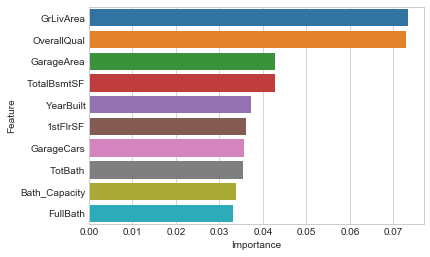

In [29]:
sns.barplot(x = 'Importance', y = 'Feature', data=result_rf1)

# Grid Search CV to Tune Random Forest

In [175]:
from sklearn.grid_search import GridSearchCV

rf_tree_cv = RandomForestRegressor(
                                bootstrap = True,
                                oob_score = True,
                                random_state = 0)

rf_param_grid = [{
        'n_estimators' : [300, 400, 500, 600], #Test[100,250,500,750,1000]
        'max_features' : np.arange(35,38), # First try: np.arange(17,40)
        #'min_samples_leaf' : np.arange(2,9),
        #'max_depth' : np.arange(5,11)
        }]

rf_grid_search = GridSearchCV(rf_tree_cv, param_grid = rf_param_grid, cv = 5)

rf_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [300, 400, 500, 600], 'max_features': array([35, 36, 37])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

## Best parameters: Max_features = 36, n_estimators = 500

In [177]:
rf_grid_search.best_params_

{'max_features': 36, 'n_estimators': 500}

# Refit Random Forest with Tuned Hyperparameters

In [178]:
rf_tree = RandomForestRegressor(n_estimators = 500,
                                max_features = 37,
                                bootstrap = True,
                                oob_score = True,
                                random_state = 0)


rf_tree.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=36, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

## R sq for Training: 98%, OOB: 87%, Test: 88%

Test score was <1% higher in the tuned Random Forest than the untuned Random Forest model

In [179]:
print('Training Score:', rf_tree.score(x_train, y_train))
print('OOB Score:', rf_tree.oob_score_)
print('Test Score:', rf_tree.score(x_test, y_test))

Training Score: 0.982891279992
OOB Score: 0.873416643755
Test Score: 0.877668748922


### Error: Training RMSE = .0526

In [180]:
from sklearn.metrics import mean_squared_error

print('Training RMSE:' , math.sqrt(mean_squared_error(y_train, rf_tree.predict(x_train))))

Training RMSE: 0.05255882012222655


### Error: Test RMSE = .1361

In [181]:
print('Test RMSE:', math.sqrt(mean_squared_error(y_test, rf_tree.predict(x_test))))

Test RMSE: 0.13609163115664372


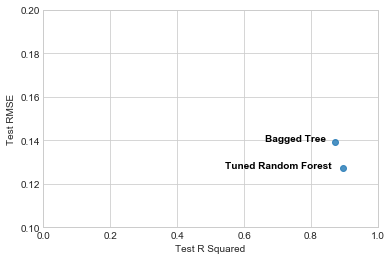

In [127]:
r = np.array([.8716, .8943])
rmse = np.array([.1394, .1274])


fig, ax = plt.subplots()
sns.regplot(x=r, y=rmse, fit_reg=False)
plt.text(.8716 - .21, .1394, "Bagged Tree", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(.8943 - .35, .1274, "Tuned Random Forest", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set(xlabel='Test R Squared', ylabel='Test RMSE')
ax.set_xlim(0,1)
ax.set_ylim(0.1000,0.2)
plt.show()

### Top 10 Important Variables

In [227]:
result = pd.concat([pd.DataFrame(x_train.columns.values),pd.DataFrame(rf_tree.feature_importances_)], axis = 1)
result.columns = ['Feature','Importance']
result = result.sort_values(by = 'Importance', ascending = False).head(10)

In [217]:
result

,feature,importance
23,OverallQual,0.100629
13,GrLivArea,0.097593
12,GarageCars,0.053279
11,GarageArea,0.051931
28,YearBuilt,0.049150
26,TotalBsmtSF,0.047400
10,FullBath,0.042848
34,TotBath,0.040406
0,1stFlrSF,0.037287
35,Bath_Capacity,0.036373


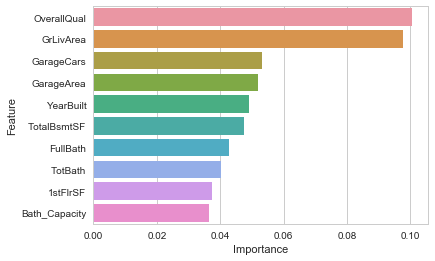

In [228]:
sns.set_style("whitegrid")
sns.barplot(x = 'Importance', y = 'Feature', data=result)

## Thoughts so far:

The random forest models had better training and test scores as well as lower MSE than the decision tree. 

The tuned Random Forest model had slightly higher R^2 than the untuned Random Forest, BUT it also had a slightly higher 

# Score Improvement From Bagged Tree To Stochastic Gradient Boosting

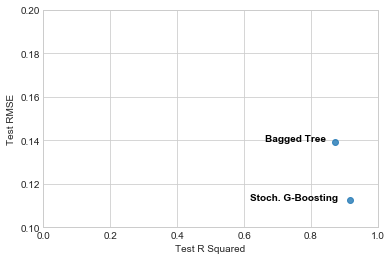

In [142]:
r = np.array([.8716, 0.9176])
rmse = np.array([.1394, 0.1125])


fig, ax = plt.subplots()
sns.regplot(x=r, y=rmse, fit_reg=False)
plt.text(.8716 - .21, .1394, "Bagged Tree", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(.9176 - .3, .1125, "Stoch. G-Boosting", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set(xlabel='Test R Squared', ylabel='Test RMSE')
ax.set_xlim(0,1)
ax.set_ylim(0.1000,0.2)
plt.show()